In [3]:
from data_prepare.dataloader import DataLoader
from modeling.neuron import Neuron
import numpy as np
import matplotlib.pyplot as plt
from typing import *

def pdprint(*args, **kwargs):
    print("[debug]", *args, **kwargs)

In [4]:
neu = Neuron()

======= Loading data =======
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_1.mat
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_2.mat
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_id_1.mat
Loading matlab file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/infer_results_id_2.mat
Loading excel file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/Infer results 1/brain_region_name1.xlsx
Loading excel file from /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/dataset/Infer results 2/brain_region_name2.xlsx


/home/kidrain61/anaconda3/envs/da/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
def plot_spikes_time_series(
    neuron, region_ids: List = [], stage_idx: int = -1, **kwargs
):
    """Plot the time series of spikes of neurons in stage(s).

    Args:
        save_pic (bool, optional): Save the picture or not. Defaults to False.
    """
    if region_ids == []:
        region_ids = neuron.categories
    save_pic = kwargs.get("save_pic", False)

    stages = {
        -1: (0, neuron.obs_len),
        0: (0, 1000),
        1: (1000, 7000),
        2: (7000, neuron.obs_len),
    }

    # select by region_ids

    region_mean_spikes = {}
    for region_id in neuron.categories:
        selection = neuron.region_id == region_id
        region_mean_spikes[region_id] = np.mean(
            neuron.data.global_S[
                selection, stages[stage_idx][0] : stages[stage_idx][1]
            ],
            axis=0,
        )
    
    # visualize
    all_region_mean_spikes = np.array(list(region_mean_spikes.values()))
    # pdprint(all_region_mean_spikes.shape)
    # pdprint(all_region_mean_spikes)
    max_region_mean_spike = np.max(all_region_mean_spikes)
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_ylim(0, max_region_mean_spike)
    for region_id in region_ids:
        spikes = region_mean_spikes[region_id]
        ax.plot(
            np.arange(spikes.shape[0]) * 0.1,
            spikes,
            c=neuron.cmap[region_id],
            label=f"Region {region_id}",
            alpha=0.5,
        )
    
    ax.set_title(
        f"Spikes Time Series of Neurons\nin Regions {region_ids if region_ids != [] else 'All'}\n\
        across {f'Stage {stage_idx+1}' if stage_idx != -1 else 'All Stages'}"
    )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Spikes")
    if not save_pic:
        fig.show()
    else:
        from pathlib import Path

        pic_root = Path.cwd() / "pics" / "时区图"
        pic_root.mkdir(parents=True, exist_ok=True)
        file_path = pic_root / f"times_{'-'.join(map(str, region_ids))}.png"
        plt.savefig(file_path)
        print(f"Created {str(file_path)}")


/tmp/ipykernel_12151/3076453721.py:50: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  f"Spikes Time Series of Neurons\nin Regions {region_ids if region_ids != [] else 'All'}\n\


Created /home/kidrain61/code/ME-XJX-2023S/math-modeling-competition/Math_Modeling/pics/时区图/times_0-20-26-53-67-81-88-95-173-187-201-228-300-327-334-348-355.png


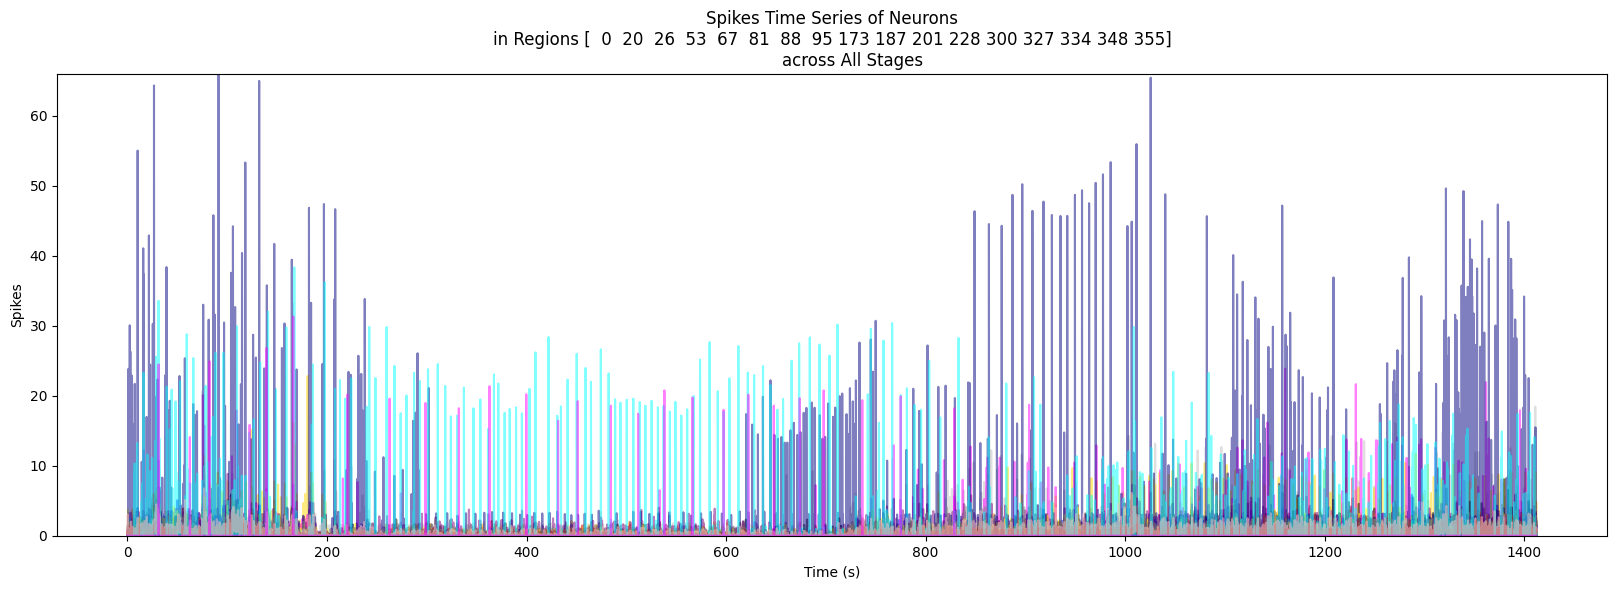

In [6]:
# plot_spikes_time_series(neu, region_ids=[], save_pic=True)
# for region_id in neu.categories:
#     plot_spikes_time_series(neu, region_ids=[region_id], save_pic=True)
#     # break

In [8]:
def devide_by_regions(neuron, data):
    region_data = {}
    for region_id in neuron.categories:
        selection = (neuron.region_id == region_id)
        region_data[region_id] = neuron.data.global_S[selection]
    return region_data

def plot_active_regions_by_steps(neuron, abs_threshhold = 0, rel_threshold = 0.8, step=100, *args, **kwargs):
    region_spikes = devide_by_regions(neu, neu.data.global_S)
    region_mean_spikes = { region_id: np.mean(region_spikes[region_id], axis=0) for region_id in neu.categories }
    # 计算每个区域的细胞平均尖峰强度，并按照时间步长分组
    max_obs_len = int((neuron.obs_len * 0.1 // step) * step * 10)
    # pdprint(max_obs_len)
    region_step_mean_spikes = { region_id: np.mean(region_mean_spikes[region_id][:max_obs_len].reshape(step * 10, -1), axis=1).transpose() for region_id in neu.categories }
    # pdprint(region_step_mean_spikes)
    # 在每一时间步中，对各区域平均尖峰强度进行排序，取最高的20%（数量向下取整）的区域计为该时间步的活跃区域，最终得到各时间步的活跃区域列表组成的列表 active_regions_in_steps
    
    # 根据 active_regions_in_steps 调用 neuron.plot_brain_regions() 绘制活跃区域随时间步变化的图像

In [9]:
def plot_active_regions_by_steps(neuron, abs_threshold=0, rel_threshold=0.8, step=100, *args, **kwargs):
    """
    绘制每一时间步的活跃区域随时间变化的图像

    Args:
    ----
    neuron: NeuronData
        NeuronData 类型的对象
    abs_threshold: float
        绝对阈值，指尖峰强度大于等于该值的被认为是尖峰，单位为微伏（uV）
    rel_threshold: float
        相对阈值，指尖峰强度在所有样本中的排名大于等于该值的被认为是尖峰
    step: int
        时间步长，单位为毫秒（ms）
    *args, **kwargs:
        可变参数和关键字参数，用于传递给 neuron.plot_brain_regions() 函数

    Returns:
    -------
    None
    """
    region_spikes = devide_by_regions(neuron, neuron.data.global_S)
    region_mean_spikes = {region_id: np.mean(region_spikes[region_id], axis=0) for region_id in neuron.categories}
    # 计算每个区域的细胞平均尖峰强度，并按照时间步长分组
    max_obs_len = int((neuron.obs_len * 0.1 // step) * step * 10)
    region_step_mean_spikes = {region_id: np.mean(region_mean_spikes[region_id][:max_obs_len].reshape(step * 10, -1), axis=1).transpose() for region_id in neuron.categories}
    # 在每一时间步中，对各区域平均尖峰强度进行排序，取最高的20%（数量向下取整）的区域计为该时间步的活跃区域，
    # 最终得到各时间步的活跃区域列表组成的列表 active_regions_in_steps
    active_regions_in_steps = []
    for i in range(region_step_mean_spikes[neuron.categories[0]].shape[1]):
        mean_spikes = []
        for region_id in neuron.categories:
            mean_spikes.append(region_step_mean_spikes[region_id][:, i])
        mean_spikes = np.array(mean_spikes)
        threshold = np.percentile(mean_spikes, (1 - rel_threshold) * 100)
        active_regions = np.argwhere(mean_spikes >= max(threshold, abs_threshold)).flatten()
        active_regions_in_steps.append(active_regions)
    # 根据 active_regions_in_steps 调用 neuron.plot_brain_regions() 绘制活跃区域随时间步变化的图像
    neuron.plot_brain_regions(active_regions_in_steps, *args, **kwargs)

In [10]:
plot_active_regions_by_steps(neu)

IndexError: tuple index out of range

# Test

In [ ]:
a = np.array([1,2,3,4])
a1 = a.reshape(2, -1)
print(a1)

[[1 2]
 [3 4]]


In [ ]:
print(neu.data.global_C.shape)
print(neu.data.global_C)
print(neu.data.global_S.shape)
print(neu.data.global_S)

In [ ]:
neuron_idx = 2
spike_units = neu.data.global_S[neuron_idx]
spike_times = np.nonzero(spike_units)
spike_durations = spike_units[spike_times]

print(spike_units)
print(spike_times)
print(spike_durations)
print(np.count_nonzero(spike_units))
plt.plot(spike_units)